In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image  # <-- This fixes your error!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
csv_path = '/content/drive/MyDrive/politifact_with_local_images.csv'
image_folder = '/content/drive/MyDrive/'
df = pd.read_csv(csv_path)
import os
# Normalize Windows-style paths to Unix-style
df['Image_Path'] = df['Image_Path'].str.replace('\\', '/', regex=False)


# Standardize column names and paths
df['image_path'] = df['Image_Path'].apply(lambda x: os.path.join(image_folder, x))

# Optional: unify text and binary label fields
df['text'] = df['Claim']

# Real vs Fake mapping (if not done yet)
real_labels = ['true', 'mostly true', 'half true']
fake_labels = ['false', 'mostly false', 'pants on fire']

def map_to_binary(rating):
    rating = str(rating).strip().lower()
    if rating in real_labels:
        return 1
    elif rating in fake_labels:
        return 0
    else:
        return None

df['binary_label'] = df['Rating'].apply(map_to_binary)
df = df.dropna(subset=['binary_label'])
df['binary_label'] = df['binary_label'].astype(int)


In [5]:
# Custom dataset
class FakeNewsBLIPDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        text = row['text']
        label = row['binary_label']


        inputs = processor(images=image, text=text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)

        # Remove batch dimension
        for k in inputs:
            inputs[k] = inputs[k].squeeze(0)

        return {**inputs, "binary_label": torch.tensor(label)}
from transformers import BlipProcessor

# Load BLIP processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [6]:
# === Split into train, validation, and test ===
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['binary_label'], random_state=42)

train_dataset = FakeNewsBLIPDataset(train_df)
val_dataset = FakeNewsBLIPDataset(val_df)
test_dataset = FakeNewsBLIPDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


In [7]:
# === Weighted loss (optional, for class imbalance) ===
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_df['binary_label']
)

weights = torch.tensor(class_weights, dtype=torch.float).cuda()
criterion = nn.CrossEntropyLoss(weight=weights)


In [8]:
from transformers import BlipModel
import torch.nn as nn

class BlipForFakeNewsClassification(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.blip = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
        self.classifier = nn.Linear(self.blip.config.projection_dim, num_labels)

    def forward(self, input_ids, pixel_values, attention_mask=None):
        outputs = self.blip(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        pooled_output = outputs.image_embeds  # or use text_embeds
        logits = self.classifier(pooled_output)
        return logits

In [9]:
# === Model setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BlipForFakeNewsClassification(num_labels=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

In [10]:
# === Model setup ===
model = BlipForFakeNewsClassification(num_labels=2).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# === Training with validation ===
best_val_acc = 0

for epoch in range(1, 11):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['binary_label'].to(device)

        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch} | Train Loss: {total_loss/len(train_loader):.4f} | Train Acc: {train_acc:.4f}")


`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_mo

Epoch 1 | Train Loss: 0.6792 | Train Acc: 0.5878
Epoch 2 | Train Loss: 0.6357 | Train Acc: 0.6429
Epoch 3 | Train Loss: 0.5864 | Train Acc: 0.7215
Epoch 4 | Train Loss: 0.5253 | Train Acc: 0.7996
Epoch 5 | Train Loss: 0.4582 | Train Acc: 0.8650
Epoch 6 | Train Loss: 0.4092 | Train Acc: 0.9062
Epoch 7 | Train Loss: 0.3804 | Train Acc: 0.9153
Epoch 8 | Train Loss: 0.3628 | Train Acc: 0.9243
Epoch 9 | Train Loss: 0.3300 | Train Acc: 0.9395
Epoch 10 | Train Loss: 0.3160 | Train Acc: 0.9431


In [11]:

    # === Validation ===
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].cuda()
            pixel_values = batch['pixel_values'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['binary_label'].cuda()

            logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print(f"→ Validation Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "blip_best_model_val.pth")
        print("✅ Best model saved.")

→ Validation Accuracy: 0.6902
✅ Best model saved.


              precision    recall  f1-score   support

        Fake       0.60      0.70      0.65       189
        Real       0.76      0.67      0.72       270

    accuracy                           0.68       459
   macro avg       0.68      0.69      0.68       459
weighted avg       0.70      0.68      0.69       459



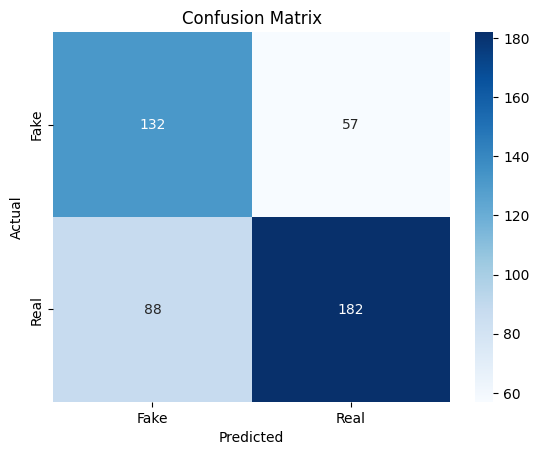

In [12]:
model.load_state_dict(torch.load("blip_best_model_val.pth"))
model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].cuda()
        pixel_values = batch['pixel_values'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['binary_label'].cuda()

        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(test_labels, test_preds, target_names=["Fake", "Real"]))

cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Predictions

In [13]:
# Make sure model is in eval mode
model.eval()

# Choose how many samples to display
num_samples = 10

# Pick samples from the test set
samples = [test_dataset[i] for i in range(num_samples)]

for i, sample in enumerate(samples):
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
    label = sample['binary_label'].item()

    with torch.no_grad():
        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        prediction = torch.argmax(logits, dim=1).item()

    print(f"--- Sample {i+1} ---")
    print(f"Claim: {test_df.iloc[i]['text']}")
    print(f"Image: {os.path.basename(test_df.iloc[i]['image_path'])}")
    print(f"True Label: {'Real' if label == 1 else 'Fake'}")
    print(f"Predicted: {'Real' if prediction == 1 else 'Fake'}")
    print()


--- Sample 1 ---
Claim: Sam Brown “said abortion should be banned without any exceptions for rape or incest.”
Image: 922.jpg
True Label: Real
Predicted: Fake

--- Sample 2 ---
Claim: “In one of the states that determined the outcome” of the 2016 presidential race, “the winning margin averaged out to just two votes per precinct, two votes.”
Image: 172.jpg
True Label: Real
Predicted: Real

--- Sample 3 ---
Claim: “My company was building the Keystone Pipeline when (President Joe) Biden canceled it.”
Image: 592.JPG
True Label: Real
Predicted: Real

--- Sample 4 ---
Claim: “Less than 500 people a year killed by all rifles combined” and “4,000 a year killed by illegals.”
Image: 1808.jpg
True Label: Fake
Predicted: Fake

--- Sample 5 ---
Claim: Vice President Kamala Harris is “calling for an end to the child tax credit.”
Image: 2151.jpg
True Label: Fake
Predicted: Real

--- Sample 6 ---
Claim: “New $40K AIDS cure is nearly 100% effective and requires two shots yearly.”
Image: 1921.jpg
True L

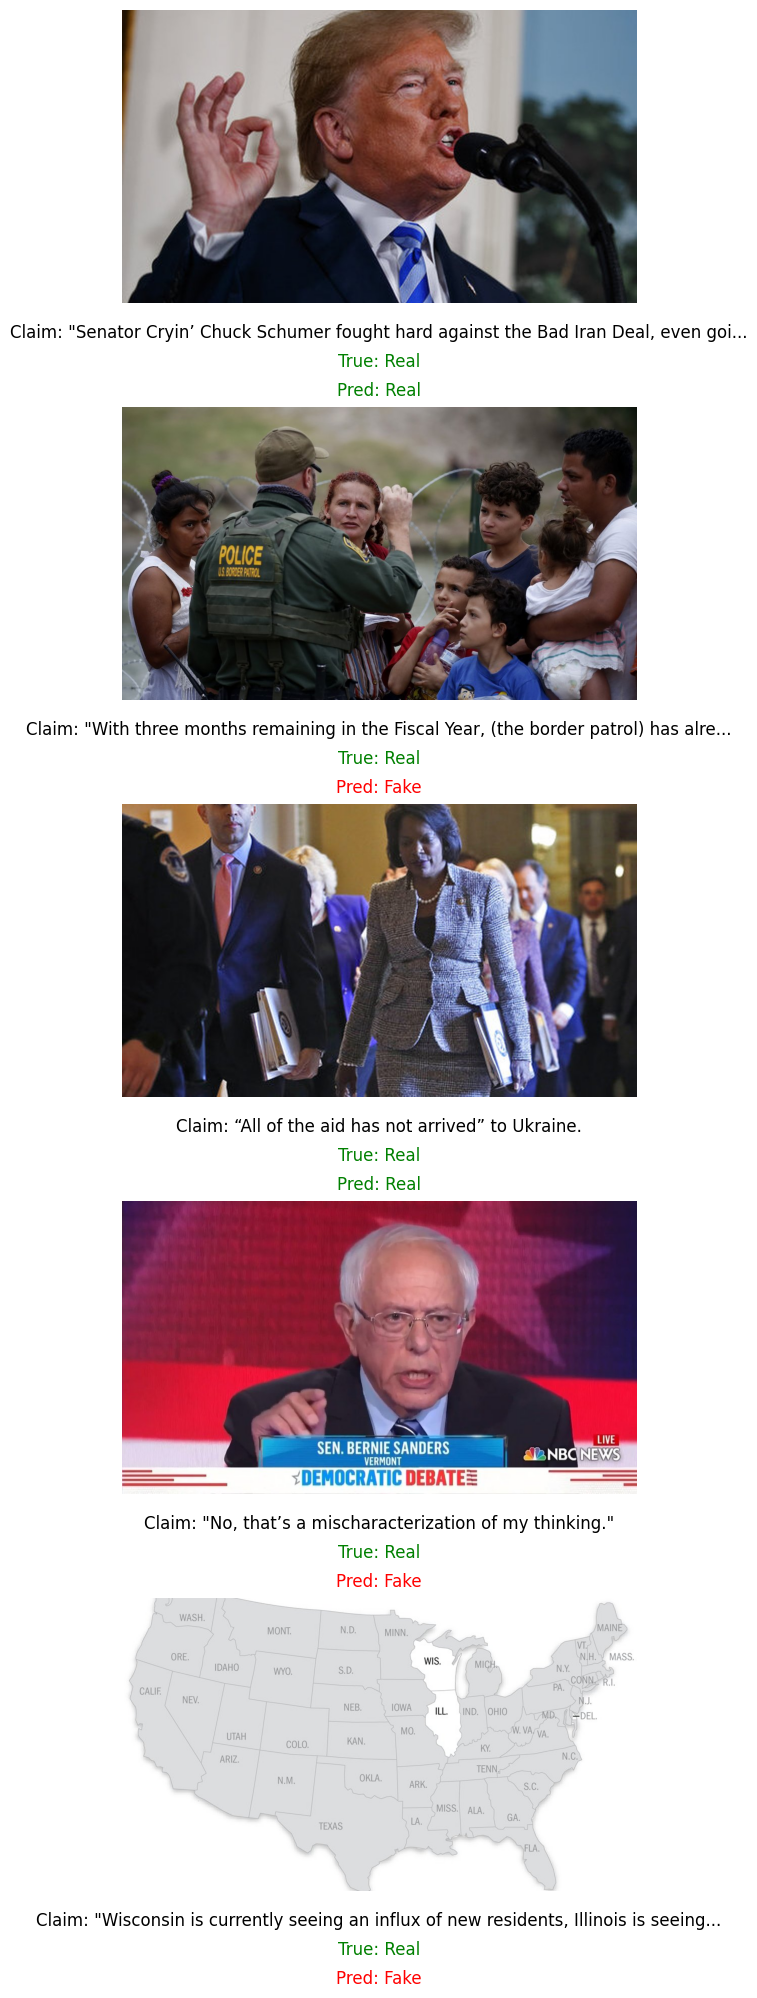

In [18]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Ensure the model is in eval mode
model.eval()

# Choose the number of samples to display
num_samples = 5

# Pick random samples from the test set
random_samples = random.sample(range(len(test_dataset)), num_samples)

# Set up the figure to hold all samples
fig = plt.figure(figsize=(12, 4 * num_samples))

for i, idx in enumerate(random_samples):
    sample = test_dataset[idx]
    input_ids = sample['input_ids'].unsqueeze(0).to(device)
    pixel_values = sample['pixel_values'].unsqueeze(0).to(device)
    attention_mask = sample['attention_mask'].unsqueeze(0).to(device)
    label = sample['binary_label'].item()

    # Get the prediction
    with torch.no_grad():
        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        prediction = torch.argmax(logits, dim=1).item()

    # Load the image to display
    image_path = test_df.iloc[idx]['image_path']
    image = Image.open(image_path)

    # Create a new subplot for each sample (1 row for each image and its details)
    ax = fig.add_subplot(num_samples, 1, i + 1)

    # Display the image
    ax.imshow(image)
    ax.axis('off')  # Hide axis

    # Get the claim text and limit length
    claim = test_df.iloc[idx]['text']
    claim_text = claim if len(claim) <= 80 else claim[:77] + '...'

    # Add claim, true label, and predicted label below the image
    ax.text(0.5, -0.1, f"Claim: {claim_text}", ha='center', va='center', transform=ax.transAxes, fontsize=12, wrap=True)
    ax.text(0.5, -0.2, f"True: {'Real' if label == 1 else 'Fake'}", ha='center', va='center', transform=ax.transAxes, fontsize=12, color='green' if label == 1 else 'red')
    ax.text(0.5, -0.3, f"Pred: {'Real' if prediction == 1 else 'Fake'}", ha='center', va='center', transform=ax.transAxes, fontsize=12, color='green' if prediction == 1 else 'red')

# Adjust layout to avoid overlap and display everything clearly
plt.tight_layout()
plt.show()
